# MICROCHIP SINGLE ELECTRON RATE CALCULATION

In [1]:
from functions_py import *
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
plt.rcParams.update({
    "image.origin": "lower",
    "image.aspect": 1,
    #"text.usetex": True,
    "grid.alpha": .5,
    "axes.linewidth":2,
    "lines.linewidth" : 1,
    "font.size":    15.0,
    "xaxis.labellocation": 'right',  # alignment of the xaxis label: {left, right, center}
    "yaxis.labellocation": 'top',  # alignment of the yaxis label: {bottom, top, center}
    "xtick.top":           True ,  # draw ticks on the top side
    "xtick.major.size":    8    ,# major tick size in points
    "xtick.minor.size":    4      ,# minor tick size in points
    "xtick.direction":     'in',
    "xtick.minor.visible": True,
    "ytick.right":           True ,  # draw ticks on the top side
    "ytick.major.size":    8    ,# major tick size in points
    "ytick.minor.size":    4      ,# minor tick size in points
    "ytick.direction":     'in',
    "ytick.minor.visible": True,
    "ytick.major.width":   2   , # major tick width in points
    "ytick.minor.width":   1 ,
    "xtick.major.width":   2   , # major tick width in points
    "xtick.minor.width":   1 ,
    "legend.framealpha": 0 ,
    "legend.loc": 'best',

})

In [121]:
path='/share/storage2/connie/data/microchip/proc_bkgd_1x10_2/proc_skp_moduleC002_bkgd_clearVB300_NBINROW10_img111.fits'


hdu_list = fits.open(path)
data_pre = precal(hdu_list,extensions=4)
gain, gain_err, data= LocalCalib(data_pre,extensions=4)
mask_bleeding_array, HE_events_array = mask_bleeding(data,direction='xy',iterations=[40,20],extensions=4,he_th=80)
data_masked=data-1e7*(mask_bleeding_array+HE_events_array)
SRE_mask_array=mask_SRE(data_masked,extensions=4,SRE_th=1.5)

masks_data=[32*mask_bleeding_array.astype('bool'),128*SRE_mask_array.astype('bool') ]
GlobalMask=np.array(masks_data).max(axis=0)

In [122]:
import numpy.ma as ma

In [123]:
event_mask=data-1e7*mask_bleeding_array
event_halo_array=[]
for i in range(4):
    
    event_halo_mask = ndimage.binary_dilation(
            (event_mask[i]>4)|mask_bleeding_array[i].astype(bool),
            iterations = 10,
            structure = ndimage.generate_binary_structure(rank=2, connectivity=2) # == [[1,1,1],[1,1,1],[1,1,1]]
        )
    event_halo_array.append(event_halo_mask)

event_halo_SR_mask = np.array(GlobalMask,dtype=bool)|np.array(event_halo_array).astype(bool)
madata=ma.masked_array(data, mask=event_halo_SR_mask)

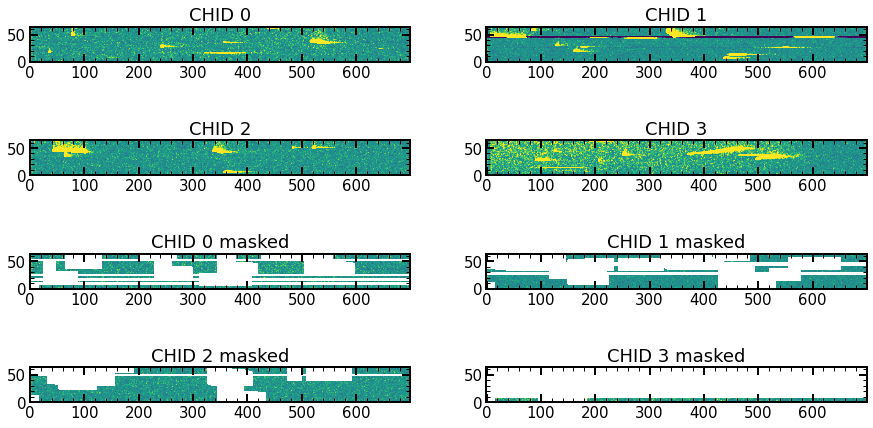

In [133]:
fig=plt.figure(figsize=(15,8))
for i in range(4): 
    plt.subplot(4,2,i+1)
    plt.imshow(data[i],vmin=-1,vmax=1)
    plt.title('CHID '+str(i))
for i in range(4): 
    plt.subplot(4,2,i+5)
    plt.imshow(madata[i],vmin=-1,vmax=1)
    plt.title('CHID '+str(i)+' masked')
fig.savefig('1x10mask.png', bbox_inches='tight', dpi=100)
plt.show()

# fig=plt.figure(figsize=(10,10))
# plt.subplot(211)
# plt.ylabel('Y_pix')
# plt.xlabel('X_pix')
# plt.title('Original Image')
# plt.imshow(data[1],vmin=-1,vmax=1)
# plt.subplot(212)
# plt.imshow(madata[1],vmin=-1,vmax=1)
# plt.ylabel('Y_pix')
# plt.xlabel('X_pix')
# plt.title('Halo+SRE Mask')
# fig.savefig('halomask.png', bbox_inches='tight', dpi=100)
# plt.show()

In [36]:

def LocalSER(data,mask,sigma,readout_time,extensions=4):
    
    madata=ma.masked_array(data, mask)
    if extensions!=1:
        
        dc_list=[]
        dc_err_list=[]
        for k in range(extensions):
            global_mask=mask[k]
            Npix=global_mask.shape[0]*global_mask.shape[1]

            time_map=np.linspace(0,readout_time,num=Npix,endpoint=True).reshape(global_mask.shape[0],global_mask.shape[1])

            time_map_mask=ma.masked_where( global_mask.astype(bool), time_map)
            Nactive=ma.count(time_map_mask)
            exposure_time=ma.mean(time_map_mask)
            print(Nactive,exposure_time)
            sigmaN=sigma[k]
            
            def poisson_normN(x, mu, A, lamb, Nmax=5): #sigma parameter global 
                y = 0.
                for i in range(0, Nmax+1):
                    y += (lamb**i)/float(math.factorial(i)) *np.exp(-0.5*((x-i-mu-lamb)/float(sigmaN))**2)
                return A*np.exp(-lamb)*y/(np.sqrt(2*np.pi*sigmaN**2))
            
            try:
                masked_hist, bins = np.histogram( ma.compressed(madata[k][convolution_mask]), np.arange(-0.5, 2.5, .01) )
                x = (bins[1:]+bins[:-1])/2
                
                popt, pcov = curve_fit( 
                    poisson_normN, 
                    x, 
                    masked_hist, 
                    p0=[-0.4, 1000, 0.05],
                )
                perr = np.sqrt(np.diag(pcov))
                dc = popt[2]/exposure_time # electron/pix/day
                dc_err = perr[2]/exposure_time # electron/pix/day                
            except (RuntimeError,OptimizeWarning,RuntimeWarning):
                print( f"Error - dc fit failed at" )
                dc, dc_err=(0,0)
            dc_list.append(dc)
            dc_err_list.append(dc_err)
        return (dc_list,dc_err_list)

In [37]:
sigma, sigma_err = LocalSigma(data,extensions=4)
start=parse(hdu_list[0].header["DATESTART"]+"Z").timestamp()
end=parse(hdu_list[0].header["DATEEND"]+"Z").timestamp()
time=datetime.timedelta(seconds=end-start)
readout_time=time.total_seconds()/86400 #readout time in days
print(readout_time)
exposure_time=readout_time/2

event_mask=data-1e7*mask_bleeding_array
event_halo_array=[]
for i in range(4):
    event_halo_mask = ndimage.binary_dilation(
            (event_mask[i]>4)|mask_bleeding_array[i].astype(bool),
            iterations = 10,
            structure = ndimage.generate_binary_structure(rank=2, connectivity=2) # == [[1,1,1],[1,1,1],[1,1,1]]
        )
    event_halo_array.append(event_halo_mask)

event_halo_SR_mask = np.array(GlobalMask,dtype=bool)|np.array(event_halo_array).astype(bool)

LocalSER(data,event_halo_SR_mask,sigma,readout_time)

0.01318287037037037
57835 0.005563217617719856
65895 0.005507861831962581
64032 0.004872912745240351
49811 0.0049891965596960035


([28.538275237325777,
  4.673207691641786,
  22.415832585272423,
  53.790198422845926],
 [0.7659159188708202,
  0.5338906584871315,
  0.6784726809891134,
  1.2571850486643192])

[-3.24660142e-02  2.70709743e+02  2.57393823e-02]


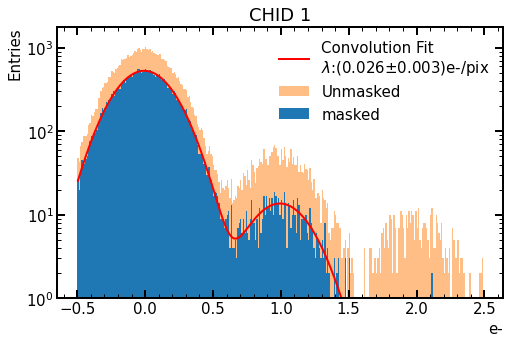

In [72]:
fig = plt.figure(figsize=(8,5))
for i in [1]:
    hist, bins = np.histogram( ma.compressed(data[i][convolution_mask]), np.arange(-0.5, 2.5, .01) )
    masked_hist, bins = np.histogram( ma.compressed(madata[i][convolution_mask]), np.arange(-0.5, 2.5, .01) )
    x = (bins[1:]+bins[:-1])/2
    plt.bar(x,hist,width=.01,label='Unmasked',color='tab:orange',alpha=.5)
    plt.bar(x,masked_hist,width=.01,label='masked',color='tab:blue')
    
    sigmaN=sigma[i]
    global_mask=event_halo_SR_mask[i]
    Npix=global_mask.shape[0]*global_mask.shape[1]

    time_map=np.linspace(0,readout_time,num=Npix,endpoint=True).reshape(global_mask.shape[0],global_mask.shape[1])

    time_map_mask=ma.masked_where( global_mask.astype(bool), time_map)
    Nactive=ma.count(time_map_mask)
    exposure_time=ma.mean(time_map_mask)        
    def poisson_normN(x, mu, A, lamb, Nmax=5): #sigma parameter global 
        y = 0.
        for i in range(0, Nmax+1):
            y += (lamb**i)/float(math.factorial(i)) *np.exp(-0.5*((x-i-mu-lamb)/float(sigmaN))**2)
        return A*np.exp(-lamb)*y/(np.sqrt(2*np.pi*sigmaN**2))

    popt, pcov = curve_fit( 
        poisson_normN, 
        x, 
        masked_hist, 
        p0=[-0.4, 1000, 0.05])
    print(popt)
    perr = np.sqrt(np.diag(pcov))
    dc = popt[2]/exposure_time # electron/pix/day
    dc_err = perr[2]/exposure_time # electron/pix/day    
plt.plot(x,poisson_normN(x,*popt),color='r',linewidth=2,label ='Convolution Fit \n'+r'$\lambda$:({:.3f}$\pm${:.3f})e-/pix'.format(popt[2],perr[2]))
plt.title('CHID 1')
plt.yscale('log')
plt.xlabel('e-')
plt.ylabel('Entries')
plt.ylim(1,1.8e3)
plt.legend()
fig.savefig('convolution.png', bbox_inches='tight', dpi=100)
plt.show()

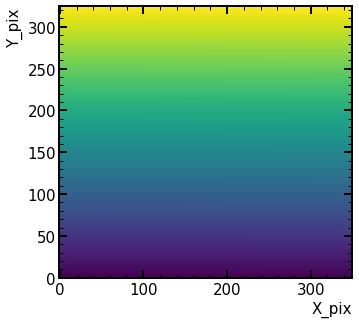

In [118]:
fig =plt.figure(figsize=(12,5))

plt.imshow(time_map)

# plt.imshow(time_map_mask)
# plt.colorbar(ticks=list(np.linspace(time_map_mask.min(), time_map_mask.max(),5)),format='%.3f',fraction=0.046, pad=0.04)

plt.ylabel('Y_pix')
plt.xlabel('X_pix')
fig.savefig('timemap.png', bbox_inches='tight', dpi=100)
plt.show()

In [11]:

for chid in range(4):
    global_mask=event_halo_SR_mask[chid]
    Npix=global_mask.shape[0]*global_mask.shape[1]

    time_map=np.linspace(0,readout_time,num=Npix,endpoint=True).reshape(global_mask.shape[0],global_mask.shape[1])

    time_map_mask=ma.masked_where( global_mask.astype(bool), time_map)
    Nactive=ma.count(time_map_mask)
    exposure_time=ma.mean(time_map_mask)
    print(Nactive,exposure_time)

139546 0.010453242932609318
119771 0.011371783405209232
110225 0.010682313187022131
81968 0.008007575401375438


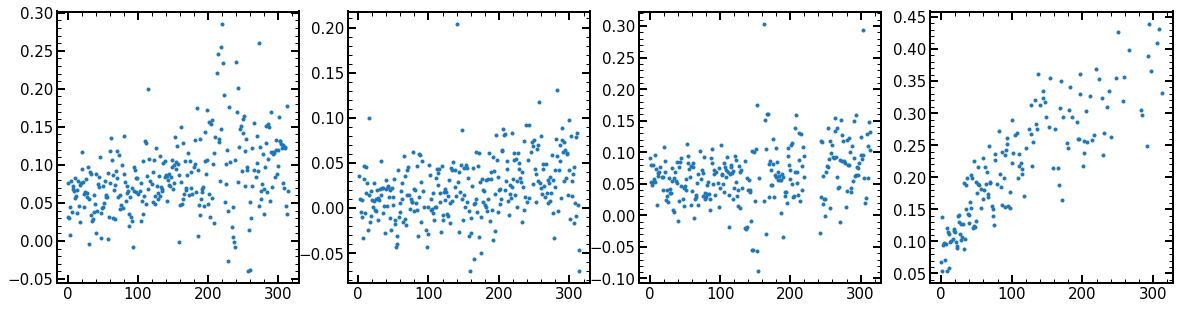

In [12]:
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(madata[i][convolution_mask].mean(axis=1),'.')
plt.show()

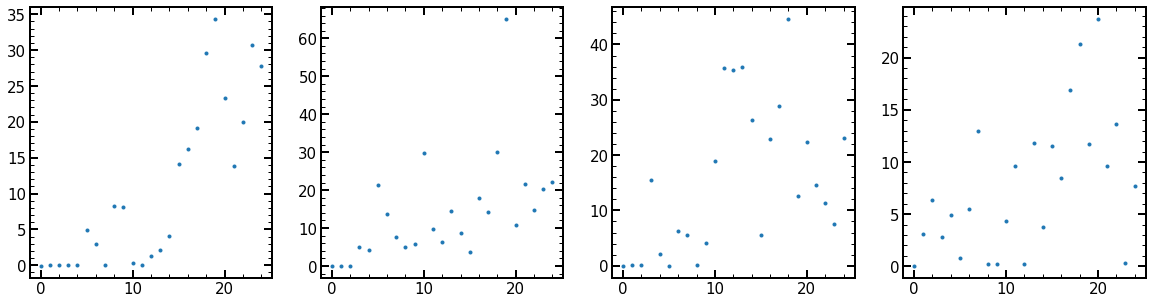

In [13]:
plt.figure(figsize=(20,5))
for i in range(4):
    plt.subplot(1,4,i+1)
    plt.plot(np.array(np.split(madata[i],25,axis=0)).mean(axis=(1,-1)),'.')
plt.show()